In [19]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import geopandas as gpd

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [40]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_2.pkl', 'rb') as file:
    bodies_df = pickle.load(file)

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

In [52]:
bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")

In [76]:
unique_coords = bodies_df.groupby('coords').count()
unique_coords = unique_coords['person_mean'].reset_index()
unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)
unique_coords['l_img'] = np.log(unique_coords['images'])
unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
unique_coords.drop('coords', axis=1, inplace=True)


coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
coords = coords.set_crs(sub_world.crs)

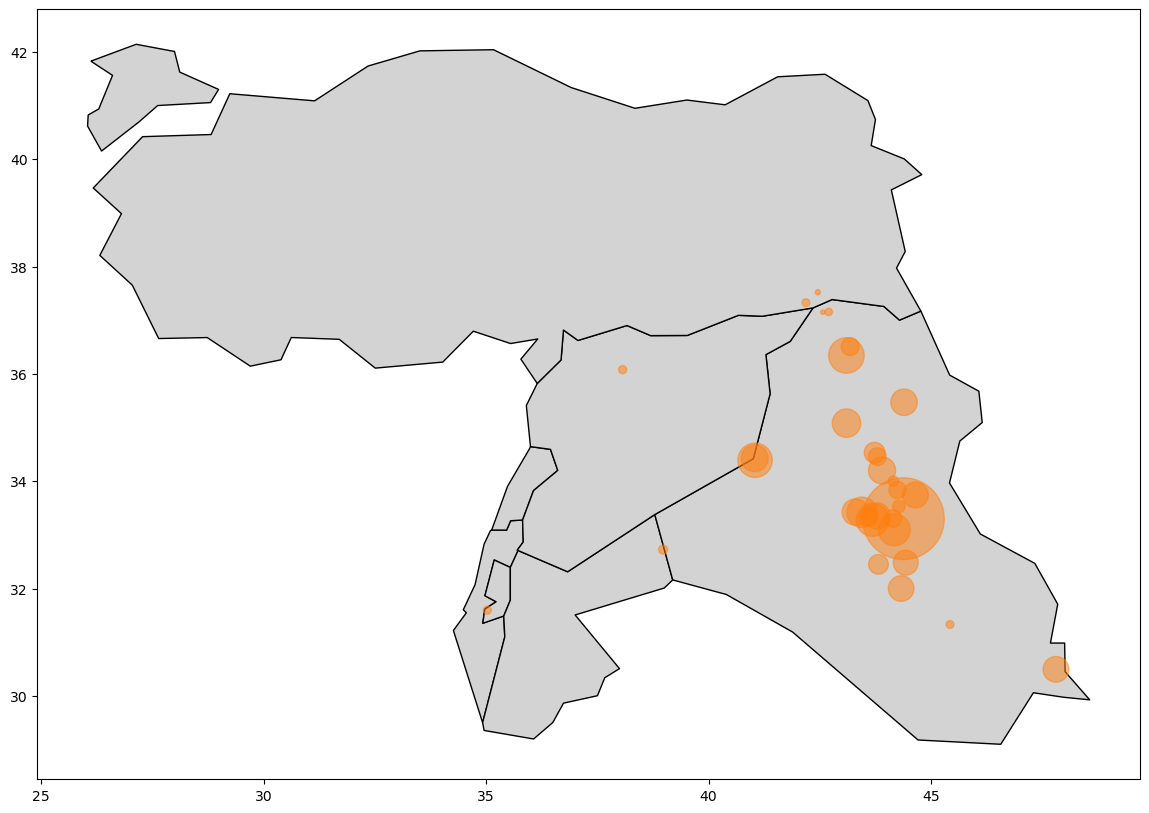

In [117]:
ax = sub_world.plot( edgecolors = 'black', color = 'lightgray', figsize=(15, 10))
coords.plot(ax=ax, color='C1', marker='o', markersize = np.sqrt(coords['images'])*10, alpha = 0.5)

plt.show()

In [87]:
coords.plot?

Signature:      coords.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x7f1646277e20>
File:           ~/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
kind: str
    The kind of plots to produce:
     - 'geo': Map (default)
     Pandas Kinds
     - 'line' : line plot
     - 'bar' : vertical bar plot
     - 'barh' : horizontal bar plot
     - 'hist' : histogram
     - 'box' : BoxPlot
     - 'kde' : Kernel Density Estima

In [30]:
plt.scatter?

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    *,
    edgecolors=None,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : array-like or list of colors or color, optional
    The marker colors. Possible values:

    - A scalar or sequence of n numbers to be mapped to colors using
      *cmap* and *norm*.
    - A 2D array in which the rows are RGB or RGBA.
    - A sequence of colors of length n.
    - A single color format string.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable from an arra

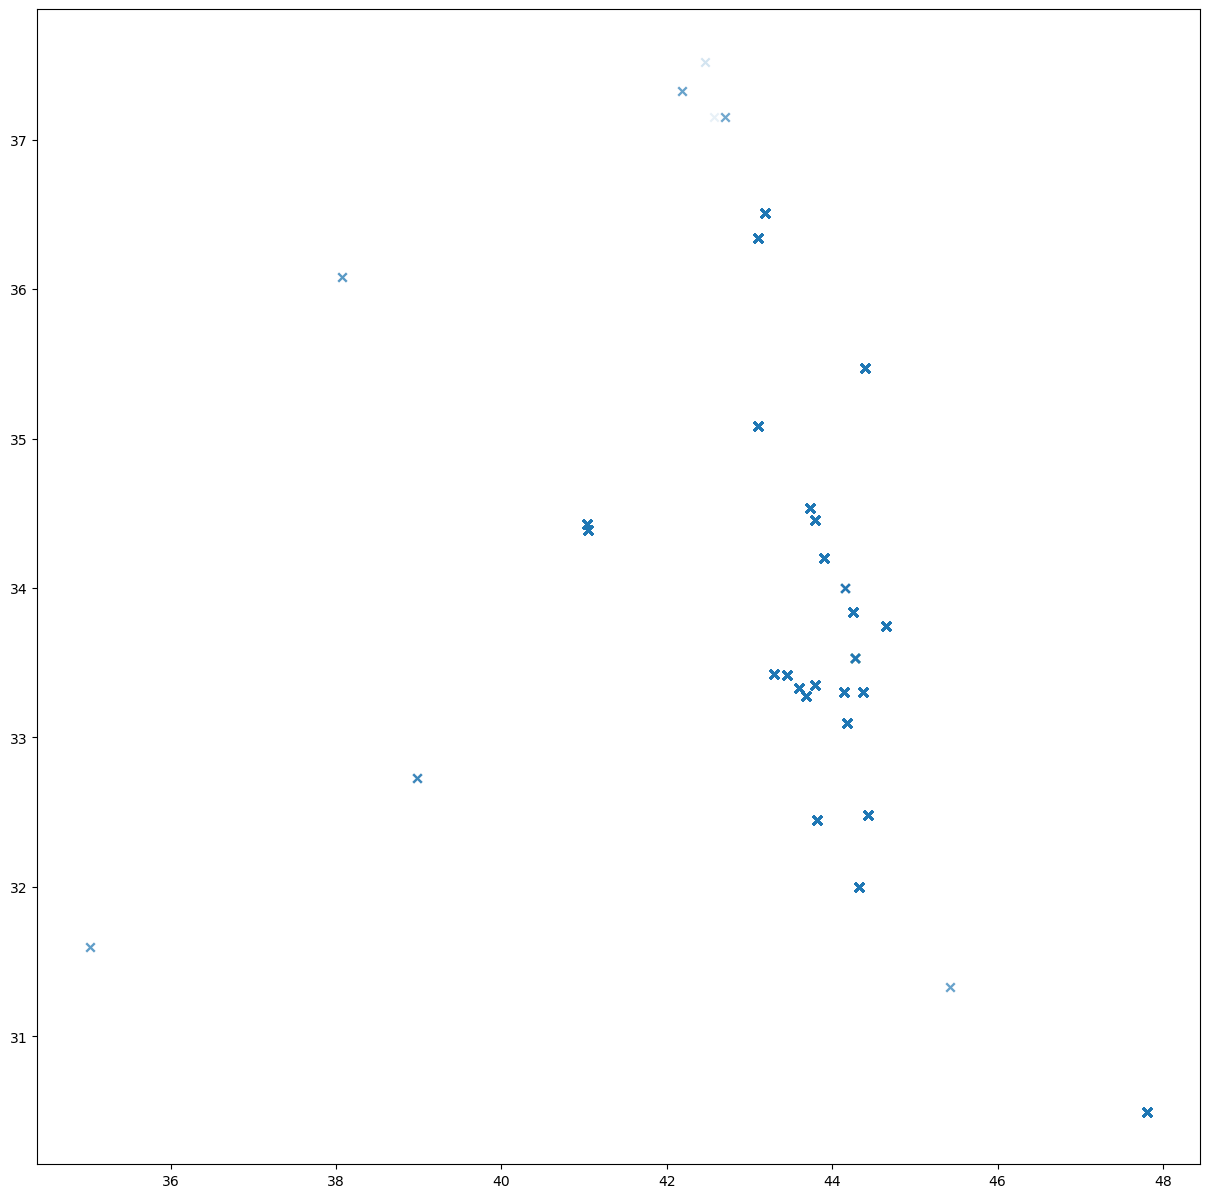

In [17]:
x = bodies_df['longitude_full']
y = bodies_df['latitude_full']

plt.figure(figsize=[15,15])
plt.scatter(x,y, marker='x', alpha= 0.1)
plt.show()

In [31]:
coords = gdp.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']])

In [34]:
coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))

<AxesSubplot: >

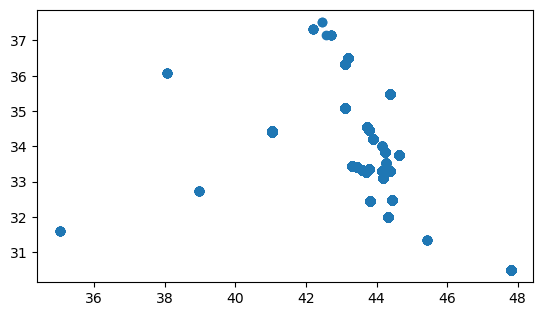

In [35]:
coords.plot()

In [ ]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
gid_geom_df = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)), ['gid', 'geometry']].drop_duplicates().copy()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()